# 反復方策評価を試す

In [1]:
V = {'L1': 0.0, 'L2': 0.0}
new_V = V.copy()

cnt = 0
while True:
    new_V['L1'] = 0.5 * (-1 + 0.9 * V['L1']) + 0.5 * (1 + 0.9 * V['L2'])
    new_V['L2'] = 0.5 * (0 + 0.9 * V['L1']) + 0.5 * (-1 + 0.9 * V['L2'])

    delta = abs(new_V['L1'] - V['L1'])
    delta = max(delta, abs(new_V['L2'] - V['L2']))
    V = new_V.copy()

    cnt += 1
    if delta < 0.0001:
        print(V)
        print(cnt)
        break


{'L1': -2.249167525908671, 'L2': -2.749167525908671}
76


# 反復方策評価の別の実装方法

In [2]:
V = {'L1': 0.0, 'L2': 0.0}

cnt = 0
while True:
    t = 0.5 * (-1 + 0.9 * V['L1']) + 0.5 * (1 + 0.9 * V['L2'])
    delta = abs(t - V['L1'])
    V['L1'] = t

    t = 0.5 * (0 + 0.9 * V['L1']) + 0.5 * (-1 + 0.9 * V['L2'])
    delta = max(delta, abs(t - V['L2']))
    V['L2'] = t

    cnt += 1
    if delta < 0.0001:
        print(V)
        print(cnt)
        break

{'L1': -2.2493782177156936, 'L2': -2.7494201578106514}
60


# GridWorldクラスの実装

In [12]:
import numpy as np
import os
import sys

sys.path.append(os.path.abspath("../"))
import common
from common import gridworld_render as render_helper

class GridWorld:
    def __init__(self):
        self.action_space = [0, 1, 2, 3]
        self.action_meaning = {
            0: "UP",
            1: "DOWN",
            2: "LEFT",
            3: "RIGHT",
        }

        self.reward_map = np.array(
            [[0, 0, 0, 1.0],
             [0, None, 0, -1.0],
             [0, 0, 0, 0]]
        )
        self.goal_state = (0, 3)
        self.wall_state = (1, 1)
        self.start_state = (2, 0)
        self.agent_state = self.start_state

    @property
    def height(self):
        return len(self.reward_map)

    @property
    def width(self):
        return len(self.reward_map[0])

    @property
    def shape(self):
        return self.reward_map.shape

    def actions(self):
        return self.action_space

    def states(self):
        for h in range(self.height):
            for w in range(self.width):
                yield (h, w)

    def next_state(self, state, action):
        #移動先の場所の計算①
        action_move_map = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        move = action_move_map[action]
        next_state = (state[0] + move[0], state[1] + move[1])
        ny, nx = next_state

        #移動先がグリッドワールドの枠の外か、
        if nx < 0 or nx >= self.width or ny < 0 or ny >= self.height:
            next_state = state
        elif next_state == self.wall_state:
            next_state = state

        return next_state

    def reward(self, state, action, next_state):
        return self.reward_map[next_state]

    def render_v(self, v=None, policy=None, print_value=True):
        renderer = render_helper.Renderer(self.reward_map, self.goal_state,
                                            self.wall_state)
        renderer.render_v(v, policy, print_value)

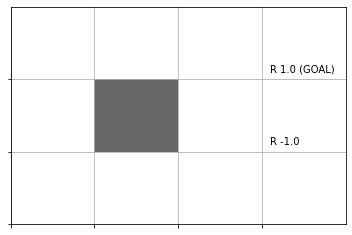

In [6]:
env = GridWorld()
env.render_v()

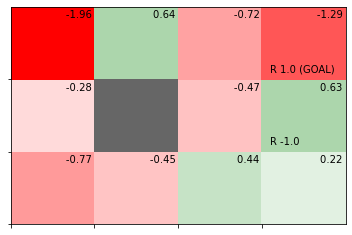

In [20]:
env = GridWorld()
V = {}
for state in env.states():
    V[state] = np.random.randn()#ダミーの状態価値関数
env.render_v(V)

# defaultdictの使い方

In [18]:
from collections import defaultdict

env = GridWorld()
V = defaultdict(lambda: 0)

state = (1,2)
print(V[state])

0


In [19]:
pi = defaultdict(lambda: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25})

state = (0, 1)
print(pi[state])

{0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}


# 反復方策評価の実装

In [23]:
def eval_onestep(pi, V, env, gamma=0.9):
    for state in env.states():
        if state == env.goal_state:
            V[state] = 0
            continue

        action_probs = pi[state]
        new_V = 0
        for action, action_prob in action_probs.items():
            next_state = env.next_state(state, action)
            r = env.reward(state, action, next_state)
            new_V += action_prob * (r + gamma * V[next_state])
        V[state] = new_V
    return V

def policy_eval(pi, V, env, gamma, threshold=0.001):
    while True:
        old_V = V.copy()
        V = eval_onestep(pi, V, env, gamma)

        delta = 0
        for state in V.keys():
            t = abs(V[state] - old_V[state])
            if delta < t:
                delta = t

        if delta < threshold:
            break
    return V

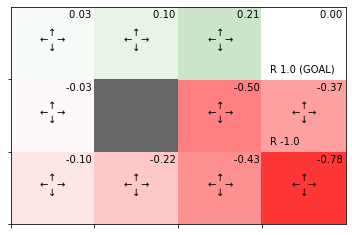

In [24]:
env = GridWorld()
gamma = 0.9

pi = defaultdict(lambda: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25})
V = defaultdict(lambda: 0)

V = policy_eval(pi, V, env, gamma)
env.render_v(V, pi)

# 方策反復法の実装

In [27]:
def argmax(d):
    """d (dict)"""
    max_value = max(d.values())
    max_key = -1
    for key, value in d.items():
        if value == max_value:
            max_key = key
    return max_key

def greedy_policy(V, env, gamma):
    pi = {}

    for state in env.states():
        action_values = {}

        for action in env.actions():
            next_state = env.next_state(state, action)
            r = env.reward(state, action, next_state)
            value = r + gamma * V[next_state]
            action_values[action] = value

        max_action = argmax(action_values)
        action_probs = {0: 0, 1: 0, 2: 0, 3: 0}
        action_probs[max_action] = 1.0
        pi[state] = action_probs
    return pi

def policy_iter(env, gamma, threshold=0.001, is_render=True):
    pi = defaultdict(lambda: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25})
    V = defaultdict(lambda: 0)

    while True:
        V = policy_eval(pi, V, env, gamma, threshold)
        new_pi = greedy_policy(V, env, gamma)

        if is_render:
            env.render_v(V, pi)

        if new_pi == pi:
            break
        pi = new_pi

    return pi

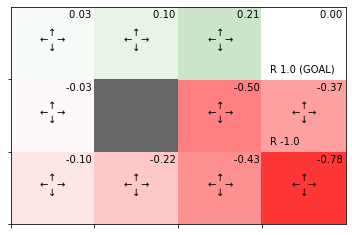

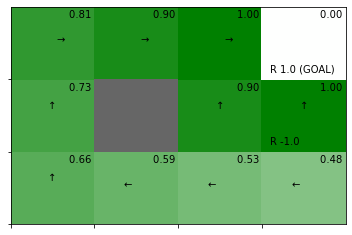

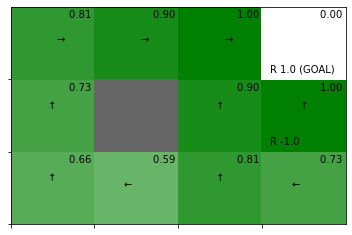

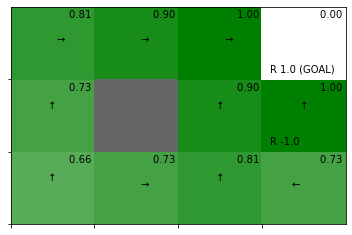

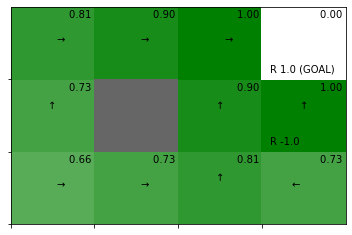

In [28]:
env = GridWorld()
gamma = 0.9
pi = policy_iter(env, gamma)
